In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os, sys

In [2]:
os.getcwd()
rpath = os.path.abspath('../')
if rpath not in sys.path:
    sys.path.insert(0,rpath)

In [3]:
data_path = os.path.join(rpath,'data','Loan Prediction data.csv')
data = pd.read_csv(data_path)


In [4]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [6]:
data.shape

(614, 13)

In [7]:
data.info

<bound method DataFrame.info of       Loan_ID  Gender Married Dependents     Education Self_Employed  \
0    LP001002    Male      No          0      Graduate            No   
1    LP001003    Male     Yes          1      Graduate            No   
2    LP001005    Male     Yes          0      Graduate           Yes   
3    LP001006    Male     Yes          0  Not Graduate            No   
4    LP001008    Male      No          0      Graduate            No   
..        ...     ...     ...        ...           ...           ...   
609  LP002978  Female      No          0      Graduate            No   
610  LP002979    Male     Yes         3+      Graduate            No   
611  LP002983    Male     Yes          1      Graduate            No   
612  LP002984    Male     Yes          2      Graduate            No   
613  LP002990  Female      No          0      Graduate           Yes   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0               5849          

In [8]:
duplicated_count = data.duplicated().sum()
duplicated_count

np.int64(0)

In [9]:
print(data.isnull().sum())

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [10]:
# Fill missing values
imputer = SimpleImputer(strategy='most_frequent')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

In [11]:
# Verify if all missing values are handled
print(data_imputed.isnull().sum())

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


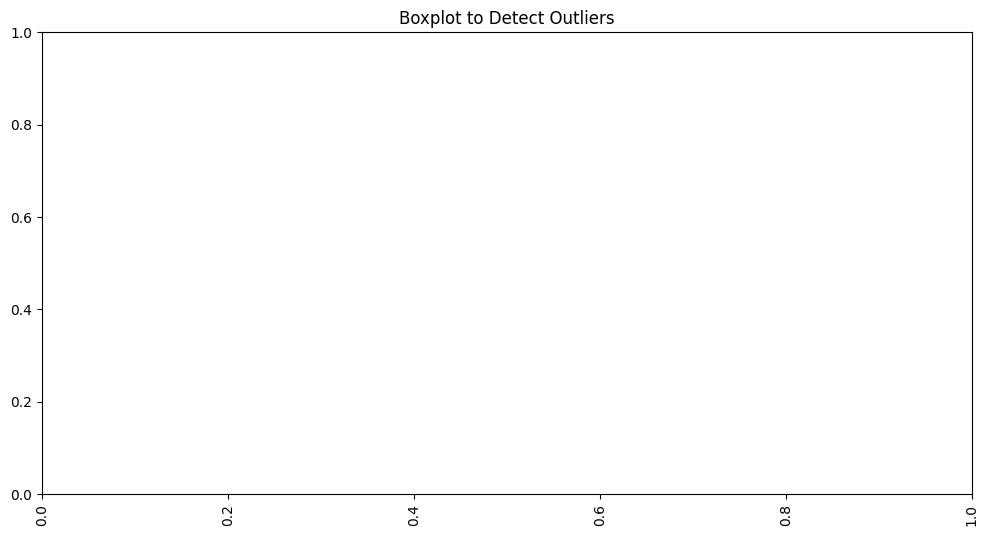

In [12]:
#Handle Outliers
plt.figure(figsize=(12,6))
sns.boxplot(data=data_imputed.select_dtypes(include=['number']))
plt.xticks(rotation=90)
plt.title("Boxplot to Detect Outliers")
plt.show()


In [13]:
# Select only numeric columns
numeric_data = data_imputed.select_dtypes(include=['number'])

# Compute Q1, Q3, and IQR
Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1

# Identifying potential outliers
outliers = ((numeric_data < (Q1 - 1.5 * IQR)) | (numeric_data > (Q3 + 1.5 * IQR))).sum()
print("Number of outliers per column:")
print(outliers)


Number of outliers per column:
Series([], dtype: float64)


In [15]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encoding categorical variables
encoder = LabelEncoder()
categorical_cols = data_imputed.select_dtypes(include=['object']).columns

for col in categorical_cols:
    data_imputed[col] = encoder.fit_transform(data_imputed[col])

# Normalize numerical features
scaler = StandardScaler()
numeric_cols = data_imputed.select_dtypes(include=['number']).columns

data_imputed[numeric_cols] = scaler.fit_transform(data_imputed[numeric_cols])

# Create a new feature: Total Income
data_imputed['TotalIncome'] = data_imputed['ApplicantIncome'] + data_imputed['CoapplicantIncome']


print("Feature Engineering Done!")


Feature Engineering Done!


In [16]:
#Exploratory Data Analysis

In [17]:
print(data_imputed.describe())


          Loan_ID        Gender       Married    Dependents     Education  \
count  614.000000  6.140000e+02  6.140000e+02  6.140000e+02  6.140000e+02   
mean     0.000000 -6.943414e-17 -8.679268e-18  4.339634e-17  1.735854e-17   
std      1.000815  1.000815e+00  1.000815e+00  1.000815e+00  1.000815e+00   
min     -1.729232 -2.117107e+00 -1.372089e+00 -7.378063e-01 -5.283622e-01   
25%     -0.864616  4.723426e-01 -1.372089e+00 -7.378063e-01 -5.283622e-01   
50%      0.000000  4.723426e-01  7.288155e-01 -7.378063e-01 -5.283622e-01   
75%      0.864616  4.723426e-01  7.288155e-01  2.534696e-01 -5.283622e-01   
max      1.729232  4.723426e-01  7.288155e-01  2.236021e+00  1.892641e+00   

       Self_Employed  ApplicantIncome  CoapplicantIncome    LoanAmount  \
count   6.140000e+02     6.140000e+02       6.140000e+02  6.140000e+02   
mean   -2.603780e-17     1.808181e-17      -4.339634e-18  2.893089e-17   
std     1.000815e+00     1.000815e+00       1.000815e+00  1.000815e+00   
min    -3.

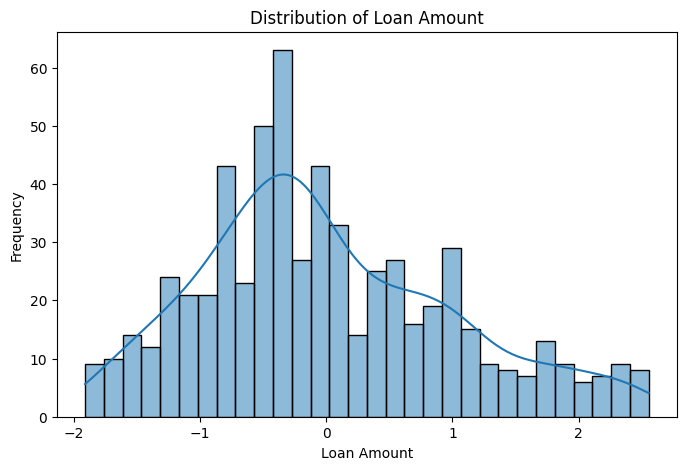

In [18]:
#Loan Amount Distribution
plt.figure(figsize=(8,5))
sns.histplot(data_imputed['LoanAmount'], kde=True, bins=30)
plt.title("Distribution of Loan Amount")
plt.xlabel("Loan Amount")
plt.ylabel("Frequency")
plt.show()


In [19]:
print(data_imputed['Gender'].unique())


[ 0.47234264 -2.11710719]


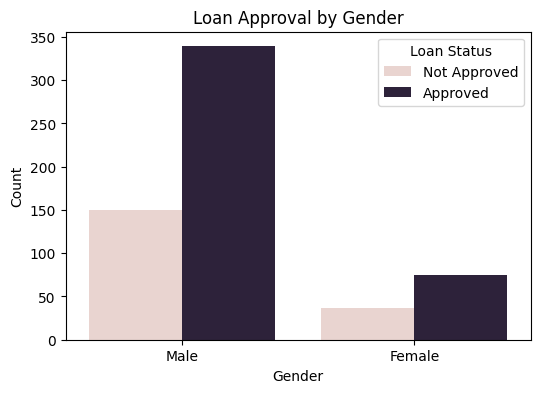

In [24]:
plt.figure(figsize=(6,4))
sns.countplot(x='Gender', hue='Loan_Status', data=data_imputed)
plt.title("Loan Approval by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Loan Status", labels=["Not Approved", "Approved"])
plt.show()


In [26]:
plt.figure(figsize=(10,6))
sns.heatmap(data_imputed.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


ValueError: could not convert string to float: 'Male'

<Figure size 1000x600 with 0 Axes>

## probability and statistics

In [27]:
#descriptive statistics
print("Mean Loan Amount:", data_imputed['LoanAmount'].mean())
print("Median Loan Amount:", data_imputed['LoanAmount'].median())
print("Mode Loan Amount:", data_imputed['LoanAmount'].mode()[0])


Mean Loan Amount: 2.8930893149841213e-17
Median Loan Amount: -0.185843155419715
Mode Loan Amount: -0.2963269832931707


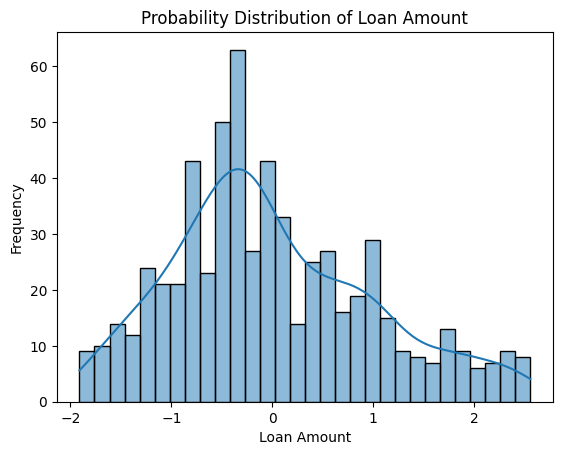

In [28]:
#probability distribution on loan amount
sns.histplot(data_imputed['LoanAmount'], kde=True, bins=30)
plt.title("Probability Distribution of Loan Amount")
plt.xlabel("Loan Amount")
plt.ylabel("Frequency")
plt.show()


In [29]:
from scipy.stats import shapiro

stat, p_value = shapiro(data_imputed['LoanAmount'])
print(f"Shapiro-Wilk Test p-value: {p_value}")

if p_value > 0.05:
    print("Loan Amount is normally distributed.")
else:
    print("Loan Amount is NOT normally distributed.")


Shapiro-Wilk Test p-value: 8.184355214190757e-10
Loan Amount is NOT normally distributed.


### correlation and hypothesis testing

In [30]:
#compute correlation between key features
print(data_imputed[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']].corr())


                   ApplicantIncome  CoapplicantIncome  LoanAmount
ApplicantIncome           1.000000          -0.248763    0.525367
CoapplicantIncome        -0.248763           1.000000    0.268146
LoanAmount                0.525367           0.268146    1.000000


In [31]:
#Hypothesis Testing: Is Loan Approval Independent of Gender
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(data_imputed['Loan_Status'], data_imputed['Gender'])

# Perform Chi-Square Test
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-square test p-value: {p}")
if p < 0.05:
    print("Loan approval depends on gender.")
else:
    print("Loan approval is independent of gender. and gender has no significant impact")


Chi-square test p-value: 0.7086529816451106
Loan approval is independent of gender. and gender has no significant impact


In [32]:
# Check data types
print(X_train.dtypes)


NameError: name 'X_train' is not defined

### ML Models

In [33]:
#Prepare data for training
# Define X (features) and y (target)
X = data_imputed.drop(columns=['Loan_Status'])  # Drop target column
y = data_imputed['Loan_Status']  # Target variable

# Split into training & testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
#Train a Model
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


ValueError: could not convert string to float: 'Male'